### 代码参考：https://aistudio.baidu.com/aistudio/projectdetail/2311230
### 本方案在此基础上，将验证集的前40000条数据划入训练集进行训练，同时经过调试，融合了roberta和ernie模型的结果
### 未保存roberta模型checkpoint，但保存了ernie的checkpoint，以及两个模型预测的概率分布

# 一.数据读取与分析

In [ ]:
# 进入比赛数据集存放目录
%cd /home/aistudio/data/data103654/

/home/aistudio/data/data103654


In [ ]:
# 使用pandas读取数据集
import pandas as pd
train = pd.read_table('train.txt', sep='\t',header=None)  # 训练集
dev = pd.read_table('dev.txt', sep='\t',header=None)      # 验证集
test = pd.read_table('test.txt', sep='\t',header=None)    # 测试集

In [ ]:
# 添加列名便于对数据进行更好处理
train.columns = ["text_a",'label']
dev.columns = ["text_a",'label']
test.columns = ["text_a"]

In [ ]:
# 拼接训练和验证集，便于统计分析
total = pd.concat([train,dev],axis=0)

In [ ]:
# 总类别标签分布统计
total['label'].value_counts()

科技    162245
股票    153949
体育    130982
娱乐     92228
时政     62867
社会     50541
教育     41680
财经     36963
家居     32363
游戏     24283
房产     19922
时尚     13335
彩票      7598
星座      3515
Name: label, dtype: int64

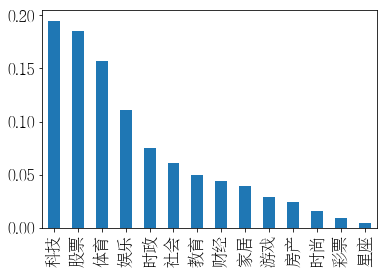

In [ ]:
# 全局设置解决matplotlib中文显示错误问题，参考：https://aistudio.baidu.com/aistudio/projectdetail/1658980
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

# 设置显示中文
matplotlib.rcParams['font.sans-serif'] = ['FZSongYi-Z13S'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 设置字体大小
matplotlib.rcParams['font.size'] = 16

# 可视化类别标签分布情况
total['label'].value_counts(normalize=True).plot(kind='bar');

In [ ]:
# 文本长度统计分析,通过分析可以看出文本较短，最长为48
total['text_a'].map(len).describe()

count    832471.000000
mean         19.388112
std           4.097139
min           2.000000
25%          17.000000
50%          20.000000
75%          23.000000
max          48.000000
Name: text_a, dtype: float64

In [ ]:
# 对测试集的长度统计分析，可以看出在长度上分布与训练数据相近
test['text_a'].map(len).describe()

count    83599.000000
mean        19.815022
std          3.883845
min          3.000000
25%         17.000000
50%         20.000000
75%         23.000000
max         84.000000
Name: text_a, dtype: float64

In [ ]:
# dev数据划一半给train进行训练
train = pd.concat([train,dev[:40000]],axis=0)
dev = dev[40000:]

In [ ]:
# 保存处理后的数据集文件
train.to_csv('train.csv', sep='\t', index=False)  # 保存训练集，格式为text_a,label
dev.to_csv('dev.csv', sep='\t', index=False)      # 保存验证集，格式为text_a,label
test.to_csv('test.csv', sep='\t', index=False)    # 保存测试集，格式为text_a

# 二.基于PaddleNLP构建基线模型

## 2.1 前置环境准备

In [ ]:
# 导入所需的第三方库
import math
import numpy as np
import os
import collections
from functools import partial
import random
import time
import inspect
import importlib
from tqdm import tqdm
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import IterableDataset
from paddle.utils.download import get_path_from_url

In [ ]:
# 下载最新版本的paddlenlp
!pip install --upgrade paddlenlp

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# 导入paddlenlp所需的相关包
import paddlenlp as ppnlp
from paddlenlp.data import JiebaTokenizer, Pad, Stack, Tuple, Vocab
from paddlenlp.datasets import MapDataset
from paddle.dataset.common import md5file
from paddlenlp.datasets import DatasetBuilder

## 2.2 定义要进行微调的预训练模型

In [ ]:
# 模型一:roberta
MODEL_NAME = "hfl/roberta-wwm-ext-large"
model = ppnlp.transformers.RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
tokenizer = ppnlp.transformers.RobertaTokenizer.from_pretrained(MODEL_NAME)

[2022-08-31 20:26:27,386] [    INFO] - Downloading https://bj.bcebos.com/paddlenlp/models/transformers/roberta_large/roberta_chn_large.pdparams and saved to /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large
[2022-08-31 20:26:27,389] [    INFO] - Downloading roberta_chn_large.pdparams from https://bj.bcebos.com/paddlenlp/models/transformers/roberta_large/roberta_chn_large.pdparams
100%|██████████| 1.21G/1.21G [00:32<00:00, 39.5MB/s]
[2022-08-31 20:27:04,582] [    INFO] - Already cached /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/vocab.txt
[2022-08-31 20:27:04,629] [    INFO] - tokenizer config file saved in /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/tokenizer_config.json
[2022-08-31 20:27:04,686] [    INFO] - Special tokens file saved in /home/aistudio/.paddlenlp/models/hfl/roberta-wwm-ext-large/special_tokens_map.json


In [ ]:
# 模型二：ernie xbase
# MODEL_NAME = "ernie-3.0-xbase-zh"
# model = ppnlp.transformers.ErnieForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14)
# tokenizer = ppnlp.transformers.ErnieTokenizer.from_pretrained(MODEL_NAME)

## 2.3 数据读取和处理

In [ ]:
# 定义要进行分类的14个类别
label_list=list(train.label.unique())
print(label_list)

['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']


In [ ]:
# 定义数据集对应文件及其文件存储格式
class NewsData(DatasetBuilder):
    SPLITS = {
        'train': 'train.csv',  # 训练集
        'dev': 'dev.csv',      # 验证集
    }

    def _get_data(self, mode, **kwargs):
        filename = self.SPLITS[mode]
        return filename

    def _read(self, filename):
        """读取数据"""
        with open(filename, 'r', encoding='utf-8') as f:
            head = None
            for line in f:
                data = line.strip().split("\t")    # 以'\t'分隔各列
                if not head:
                    head = data
                else:
                    text_a, label = data
                    yield {"text_a": text_a, "label": label}  # 此次设置数据的格式为：text_a,label，可以根据具体情况进行修改

    def get_labels(self):
        return label_list   # 类别标签

In [ ]:
# 定义数据集加载函数
def load_dataset(name=None,
                 data_files=None,
                 splits=None,
                 lazy=None,
                 **kwargs):
   
    reader_cls = NewsData  # 加载定义的数据集格式
    print(reader_cls)
    if not name:
        reader_instance = reader_cls(lazy=lazy, **kwargs)
    else:
        reader_instance = reader_cls(lazy=lazy, name=name, **kwargs)

    datasets = reader_instance.read_datasets(data_files=data_files, splits=splits)
    return datasets

In [ ]:
# 加载训练和验证集
train_ds, dev_ds = load_dataset(splits=["train", "dev"])

<class '__main__.NewsData'>


In [ ]:
# 定义数据加载和处理函数
def convert_example(example, tokenizer, max_seq_length=128, is_test=False):
    qtconcat = example["text_a"]
    encoded_inputs = tokenizer(text=qtconcat, max_seq_len=max_seq_length)  # tokenizer处理为模型可接受的格式 
    input_ids = encoded_inputs["input_ids"]
    token_type_ids = encoded_inputs["token_type_ids"]

    if not is_test:
        label = np.array([example["label"]], dtype="int64")
        return input_ids, token_type_ids, label
    else:
        return input_ids, token_type_ids

# 定义数据加载函数dataloader
def create_dataloader(dataset,
                      mode='train',
                      batch_size=1,
                      batchify_fn=None,
                      trans_fn=None):
    if trans_fn:
        dataset = dataset.map(trans_fn)

    shuffle = True if mode == 'train' else False
    # 训练数据集随机打乱，测试数据集不打乱
    if mode == 'train':
        batch_sampler = paddle.io.DistributedBatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        batch_sampler = paddle.io.BatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)

    return paddle.io.DataLoader(
        dataset=dataset,
        batch_sampler=batch_sampler,
        collate_fn=batchify_fn,
        return_list=True)

In [ ]:
# 参数设置:
# 批处理大小，显存如若不足的话可以适当改小该值
batch_size = 128
# 文本序列最大截断长度，需要根据文本具体长度进行确定，最长不超过512。 通过文本长度分析可以看出文本长度最大为48，故此处设置为48
max_seq_length = 48

In [ ]:
# 将数据处理成模型可读入的数据格式
trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)

batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack()  # labels
): [data for data in fn(samples)]

# 训练集迭代器
train_data_loader = create_dataloader(
    train_ds,
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

# 验证集迭代器
dev_data_loader = create_dataloader(
    dev_ds,
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

## 2.4 设置Fine-Tune优化策略，接入评价指标

适用于BERT这类Transformer模型的学习率为warmup的动态学习率。

In [ ]:
# 定义超参，loss，优化器等
from paddlenlp.transformers import LinearDecayWithWarmup

# 定义训练配置参数：
# 定义训练过程中的最大学习率
learning_rate = 2e-5
# 训练轮次
epochs = 4
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.02
max_grad_norm = 1.0

num_training_steps = len(train_data_loader) * epochs
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)

# AdamW优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    grad_clip=paddle.nn.ClipGradByGlobalNorm(max_grad_norm), 
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

criterion = paddle.nn.loss.CrossEntropyLoss()  # 交叉熵损失函数
metric = paddle.metric.Accuracy()              # accuracy评价指标

## 2.5 模型训练与评估

In [ ]:
# 定义模型训练验证评估函数
@paddle.no_grad()
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    losses = []
    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        logits = model(input_ids, token_type_ids)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        correct = metric.compute(logits, labels)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.5f, accu: %.5f" % (np.mean(losses), accu))  # 输出验证集上评估效果
    model.train()
    metric.reset()
    return accu  # 返回准确率

In [ ]:
# 固定随机种子便于结果的复现
seed = 1024
random.seed(seed)
np.random.seed(seed)
paddle.seed(seed)

ps:模型训练时可以通过在终端输入nvidia-smi命令查看显存占用情况，显存不足的话要适当调整好训练batchsize的值。

In [ ]:
# 模型训练：
# 如仅需复现结果，可跳过以下训练和验证部分，直接进入第3部分：模型融合
import paddle.nn.functional as F

save_dir = "checkpoint"
if not  os.path.exists(save_dir):
    os.makedirs(save_dir)

pre_accu=0
accu=0
global_step = 0
for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()

        global_step += 1
        if global_step % 10 == 0 :
            print("global step %d, epoch: %d, batch: %d, loss: %.5f, acc: %.5f" % (global_step, epoch, step, loss, acc))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()
    # 每轮结束对验证集进行评估
    accu = evaluate(model, criterion, metric, dev_data_loader)
    print(accu)
    if accu > pre_accu:
        # 保存较上一轮效果更优的模型参数
        save_param_path = os.path.join(save_dir, 'model_state.pdparams')  # 保存模型参数
        paddle.save(model.state_dict(), save_param_path)
        pre_accu=accu
tokenizer.save_pretrained(save_dir)

In [81]:
# 加载在验证集上效果最优的一轮的模型参数
import os
import paddle

# params_path = 'checkpoint/model_state.pdparams'
params_path = 'data/data168122/model_state.pdparams'
if params_path and os.path.isfile(params_path):
    # 加载模型参数
    state_dict = paddle.load(params_path)
    model.set_dict(state_dict)
    print("Loaded parameters from %s" % params_path)

Loaded parameters from checkpoint/model_state.pdparams


In [ ]:
# 移动保存模型
!cp -r /home/aistudio/checkpoint/model_state.pdparams /home/aistudio/

In [ ]:
# 测试最优模型参数在验证集上的分数
evaluate(model, criterion, metric, dev_data_loader)

## 2.6 模型预测

In [82]:
# 定义模型预测函数
def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    # 将输入数据（list格式）处理为模型可接受的格式
    for text in data:
        input_ids, segment_ids = convert_example(
            text,
            tokenizer,
            max_seq_length=128,
            is_test=True)
        examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input id
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # segment id
    ): fn(samples)

    # Seperates data into some batches.
    batches = []
    one_batch = []
    for example in examples:
        one_batch.append(example)
        if len(one_batch) == batch_size:
            batches.append(one_batch)
            one_batch = []
    if one_batch:
        # The last batch whose size is less than the config batch_size setting.
        batches.append(one_batch)

    results = []
    logits_ls = []
    model.eval()
    for batch in batches:
        input_ids, segment_ids = batchify_fn(batch)
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)
        logits_ls.append(logits.numpy())
        probs = F.softmax(logits, axis=1)
        idx = paddle.argmax(probs, axis=1).numpy()
        idx = idx.tolist()
        labels = [label_map[i] for i in idx]
        results.extend(labels)
    return results, logits_ls  # 返回预测结果

In [83]:
# 定义要进行分类的类别
label_list=list(train.label.unique())
label_map = { 
    idx: label_text for idx, label_text in enumerate(label_list)
}
print(label_map)

{0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}


In [84]:
# 读取要进行预测的测试集文件
test = pd.read_csv('./test.csv',sep='\t')  

In [85]:
# 定义对数据的预处理函数,处理为模型输入指定list格式
def preprocess_prediction_data(data):
    examples = []
    for text_a in data:
        examples.append({"text_a": text_a})
    return examples

# 对测试集数据进行格式处理
data1 = list(test.text_a)
examples = preprocess_prediction_data(data1)

In [86]:
# 对测试集进行预测
results, logits_ls = predict(model, examples, tokenizer, label_map, batch_size=16)   

In [87]:
# 存一下logits
np.save('/home/aistudio/logits_roberta.npy', logits_ls)   # roberta线上分数为0.890
# np.save('/home/aistudio/logits_ernie.npy', logits_ls)   # ernie线上分数为0.889

# 三.模型融合

模型融合的效果还是不错的。roberta线上分数为0.890，ernie线上分数0.889，而两个模型融合后最好结果达到0.984

In [97]:
logits_ernie = np.load('/home/aistudio/logits_ernie.npy', allow_pickle=True)
logits_roberta = np.load('/home/aistudio/logits_roberta.npy', allow_pickle=True)

In [98]:
results = []
for i in range(len(logits_ernie)):
    logits_1 = logits_ernie[i]
    logits_2 = logits_roberta[i]
    logits = 0.62 * logits_1 + 0.38 * logits_2   # 目前最好的融合结果:0.62+0.38
    logits = paddle.to_tensor(logits)
    probs = F.softmax(logits, axis=1)
    idx = paddle.argmax(probs, axis=1).numpy()
    idx = idx.tolist()
    labels = [label_map[i] for i in idx]
    results.extend(labels)

In [99]:
# 将list格式的预测结果存储为txt文件，提交格式要求：每行一个类别
def write_results(labels, file_path):
    with open(file_path, "w", encoding="utf8") as f:
        f.writelines("\n".join(labels))

write_results(results, "./result.txt")

In [100]:
# 因格式要求为zip，故需要将结果文件压缩为submission.zip提交文件
!zip 'submission.zip' 'result.txt'

updating: result.txt (deflated 89%)


In [101]:
# 移动data目录下提交结果文件至主目录下，便于结果文件的保存
!cp -r /home/aistudio/data/data103654/submission.zip /home/aistudio/